In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn as sk

from pymatgen.io.cif import CifParser
import pickle
plt.rcParams['font.size'] = '15'

2023-07-15 15:46:25.158202: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 15:46:25.244129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 15:46:25.246390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 15:46:26.269723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# define some parameters
# Constant
k2kjmol = 0.00831446 # constants. Convert K to kJ/mol

# number of movie frames
nframe = 10000 

# MOF information
mof_file = "MgMOF-74-1x1x1-P1-VASP_charged.cif"
sc_fac=  [1,1,2] # multiply by this vector to get a supercell

# Movie file
movie_file = "Movies/System_0/Movie_MgMOF-74-1x1x1-P1-VASP_charged_1.1.2_80000.000000_0.000000_allcomponents.pdb"

In [4]:
# load txt data using numpy and omit header
#h2o_coords = np.loadtxt('DFT_Datasets/H2O/H2O_Coordinates.dat', skiprows=1)
energy = np.loadtxt('host-ads_energies.txt')
energy = energy * k2kjmol # convert to kJ/mol

In [5]:
# Initialize a CifParser object
parser = CifParser(mof_file)

# Parse the CIF file and obtain a Structure object
structure = parser.get_structures(primitive=False)[0]

supercell = structure * sc_fac

In [6]:
# define a distance function
def pairdist(host_site, ads_frac,supercell):

    da = host_site.frac_coords[0] - ads_frac[0]
    db = host_site.frac_coords[1] - ads_frac[1]
    dc = host_site.frac_coords[2] - ads_frac[2]
    
    # minimum image convension
    da -= round(da)
    db -= round(db)
    dc -= round(dc)

    # distance
    cart_coords = supercell.lattice.get_cartesian_coords(np.array([da,db,dc]))
    dist2 = cart_coords[0]**2 + cart_coords[1]**2 + cart_coords[2]**2
    dist = np.sqrt(dist2)
    
    return dist

# define a unique feature function
def dist_feature(r):
    return np.array([np.exp(-r),r**(-1),r**(-4),r**(-6),r**(-8),r**(-10)])

In [7]:
# read PDF file
f = open(movie_file)

# initialize feature
feature = np.array([])

# loop over each frame
for i in range(nframe):
    
    ch4mg = np.array([])
    ch4o = np.array([])
    ch4c = np.array([])
    ch4h = np.array([])


    # read first two lines
    line = [next(f).strip().split() for x in range(2)]

    while 1:
        line = next(f).strip().split()

        if line[0] == 'ENDMDL':
            break

        # skip pseudo atom
        if line[2] == 'L':
            continue

        # read in coordinates of atoms in an adsorbate molecule
        ads_frac = supercell.lattice.get_fractional_coords(np.array([float(line[4]),
                                                                     float(line[5]),
                                                                     float(line[6])]))
        
        if line[2] == 'Ar':
            
            # loop over all framework atoms:
            for site in supercell:

                # calculate pair distance
                dist = pairdist(site, ads_frac,supercell)
            
                if site.species_string == 'Mg':
                    ch4mg = np.append(ch4mg,dist)
                elif site.species_string == 'O':
                    ch4o = np.append(ch4o,dist)
                elif site.species_string == 'C':
                    ch4c = np.append(ch4c,dist)
                elif site.species_string == 'H':
                    ch4h = np.append(ch4h,dist)

           
                
    # sort array in ascending order
    ch4mg = np.sort(ch4mg)
    ch4o = np.sort(ch4o)
    ch4c = np.sort(ch4c)
    ch4h = np.sort(ch4h)


    # pick the first 9 elements in array and add them to feature array
    for k in range(9):
        feature = np.append(feature, dist_feature(ch4mg[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(ch4o[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(ch4c[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(ch4h[k]))


    print('finished frame: {}'.format(i+1))

finished frame: 1
finished frame: 2
finished frame: 3
finished frame: 4
finished frame: 5
finished frame: 6
finished frame: 7
finished frame: 8
finished frame: 9
finished frame: 10
finished frame: 11
finished frame: 12
finished frame: 13
finished frame: 14
finished frame: 15
finished frame: 16
finished frame: 17
finished frame: 18
finished frame: 19
finished frame: 20
finished frame: 21
finished frame: 22
finished frame: 23
finished frame: 24
finished frame: 25
finished frame: 26
finished frame: 27
finished frame: 28
finished frame: 29
finished frame: 30
finished frame: 31
finished frame: 32
finished frame: 33
finished frame: 34
finished frame: 35
finished frame: 36
finished frame: 37
finished frame: 38
finished frame: 39
finished frame: 40
finished frame: 41
finished frame: 42
finished frame: 43
finished frame: 44
finished frame: 45
finished frame: 46
finished frame: 47
finished frame: 48
finished frame: 49
finished frame: 50
finished frame: 51
finished frame: 52
finished frame: 53
fi

In [8]:
# reshape
feature = feature.reshape(-1, 216)
energy = energy.reshape(-1, 1)

print(feature.shape)
print(energy.shape)

# save feature and energy to a pickle file
with open('feature_energy.pickle', 'wb') as f:
    pickle.dump([feature, energy], f)

(10000, 216)
(10000, 1)


In [2]:
# load in "feature_energy.pickle" file and it contains a list of two arrays
with open('feature_energy.pickle', 'rb') as f:
    feature, energy = pickle.load(f)

feature.shape

(10000, 216)

In [3]:
# split feature into training and testing set
# I want 1000 data points to be in the testing set
X_train, X_test, y_train, y_test = train_test_split(feature, energy, test_size=1000, random_state=42)

# use min-max to normalize feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
mini = scaler.data_min_
maxi = scaler.data_max_

# write mini and maxi array to the same file
with open('minimax.txt', 'w') as f:
    for i in range(len(mini)):
        f.write('{} {}\n'.format(mini[i], maxi[i]))


In [5]:
tf.keras.backend.set_floatx('float32')

In [6]:
# A deep neural network with 5 hidden layers with 50 neurons each, use ReLU as activation function and learning rate of 0.001, 1000 epochs
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    # output layer with one neuron
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Train the model with early stopping
# this early stop criteria is to stop training when the validation loss does not decrease for xx consecutive epochs (adopted by Max Welling et al.)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
# reduce learning rate when validation loss does not decrease for 10 consecutive epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=1e-6)
# train the model with validation set from training set=20%
history = model.fit(X_train, y_train, epochs=100000, batch_size = 16, validation_split=0.11111, verbose=1, callbacks=[early_stop, reduce_lr])

Epoch 1/100000
500/500 [==============================] - 3s 3ms/step - loss: 14060.7246 - mean_absolute_error: 41.1378 - val_loss: 1709.2434 - val_mean_absolute_error: 20.8028 - lr: 0.0010
Epoch 2/100000
500/500 [==============================] - 1s 2ms/step - loss: 2318.6445 - mean_absolute_error: 16.6884 - val_loss: 1190.0320 - val_mean_absolute_error: 11.7065 - lr: 0.0010
Epoch 3/100000
500/500 [==============================] - 1s 2ms/step - loss: 1225.8893 - mean_absolute_error: 11.8960 - val_loss: 1046.8752 - val_mean_absolute_error: 12.1191 - lr: 0.0010
Epoch 4/100000
500/500 [==============================] - 1s 2ms/step - loss: 1170.1034 - mean_absolute_error: 11.2820 - val_loss: 1144.0524 - val_mean_absolute_error: 12.9772 - lr: 0.0010
Epoch 5/100000
500/500 [==============================] - 1s 2ms/step - loss: 910.9819 - mean_absolute_error: 10.0821 - val_loss: 545.5269 - val_mean_absolute_error: 8.6725 - lr: 0.0010
Epoch 6/100000
500/500 [==============================] -

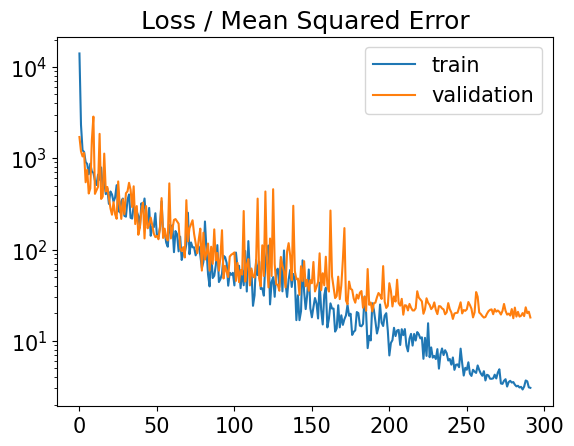

In [8]:
# plot the loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.yscale('log')

32/32 [==============================] - 0s 2ms/step


Text(-50, 250, 'MAE = 1.64 kJ/mol')

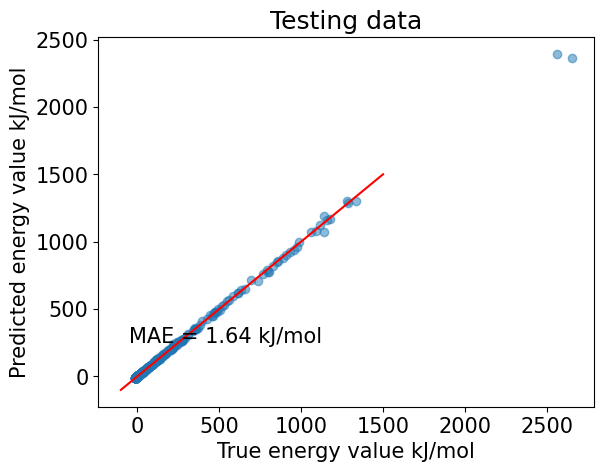

In [9]:
# Evaluate the model using mean absolute error
model.evaluate(X_test, y_test)

# predict value based on a test set
y_pred = model.predict(X_test)


plt.plot(y_test, y_pred, 'o',alpha=0.5)
# draw a line of y=x
plt.plot([-100, 1500], [-100, 1500], 'r-')
plt.xlabel('True energy value kJ/mol')
plt.ylabel('Predicted energy value kJ/mol')
plt.title('Testing data')
# write the mean absolute error to the plot
plt.text(-50, 250, 'MAE = {:.2f} kJ/mol'.format(sk.metrics.mean_absolute_error(y_test, y_pred)))

282/282 [==============================] - 0s 1ms/step


Text(-50, 250, 'MAE = 0.74 kJ/mol')

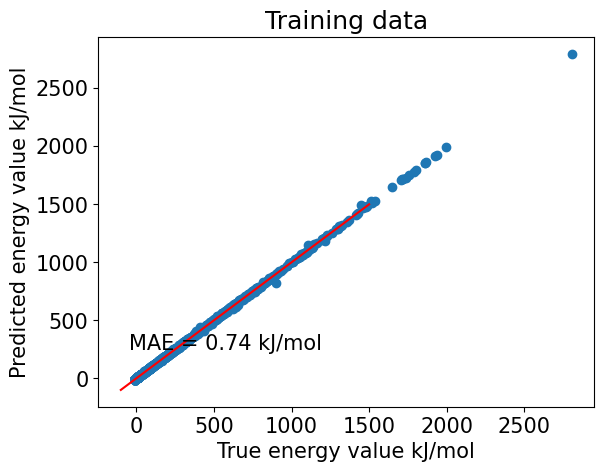

In [10]:
# predict value based on a test set
y_pred_train = model.predict(X_train)

plt.plot(y_train, y_pred_train, 'o')
# draw a line of y=x
plt.plot([-100, 1500], [-100, 1500], 'r-')
plt.xlabel('True energy value kJ/mol')
plt.ylabel('Predicted energy value kJ/mol')
plt.title('Training data')
# write the mean absolute error to the plot
plt.text(-50, 250, 'MAE = {:.2f} kJ/mol'.format(sk.metrics.mean_absolute_error(y_train, y_pred_train)))

In [11]:
# save the model using SavedModel format
model.save('DP_model_Ar_MgMOF74_float32')


INFO:tensorflow:Assets written to: DP_model_Ar_MgMOF74_float32/assets


INFO:tensorflow:Assets written to: DP_model_Ar_MgMOF74_float32/assets


In [5]:
# load the model
model = tf.keras.models.load_model('DP_model_Ar_MgMOF74_float32')

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 1ms/step


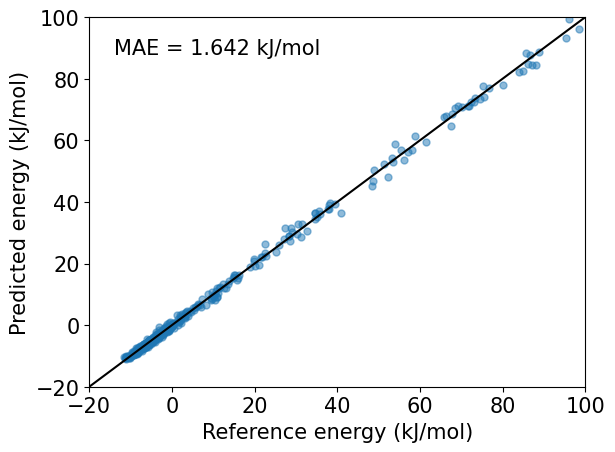

In [7]:
# predict value based on a test set
y_pred = model.predict(X_test)

plt.plot(y_test, y_pred, 'o', markersize=5, alpha=0.5)
plt.plot([-200, 1000], [-200, 1000], '-', color='black')
plt.xlabel('Reference energy (kJ/mol)')
plt.ylabel('Predicted energy (kJ/mol)')
plt.xlim([-20, 100])
plt.ylim([-20, 100])
# mark the MAE
plt.text(0.05, 0.9, 'MAE = %.3f kJ/mol' % np.mean(np.abs(np.array(y_test) - np.array(y_pred))), transform=plt.gca().transAxes)

# save to figure
plt.savefig('PP_Ar_lin.png', dpi=300, bbox_inches='tight')

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 1ms/step


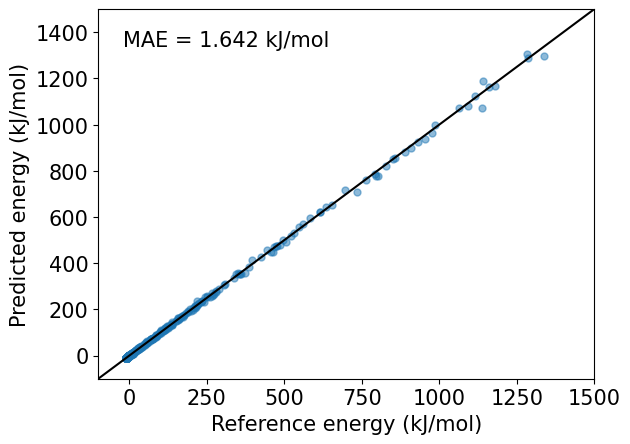

In [10]:
# predict value based on a test set
y_pred = model.predict(X_test)

plt.plot(y_test, y_pred, 'o', markersize=5, alpha=0.5)
plt.plot([-200, 1500], [-200, 1500], '-', color='black')
plt.xlabel('Reference energy (kJ/mol)')
plt.ylabel('Predicted energy (kJ/mol)')
plt.xlim([-100, 1500])
plt.ylim([-100, 1500])
# mark the MAE
plt.text(0.05, 0.9, 'MAE = %.3f kJ/mol' % np.mean(np.abs(np.array(y_test) - np.array(y_pred))), transform=plt.gca().transAxes)

# save to figure
plt.savefig('PP_Ar_lin_full.png', dpi=300, bbox_inches='tight')